# 2.2.4.4 Image Data

Earlier in this module, we introduced image data as a 2d or 3d tensor representing pixel values.

Commonly, we may wish to resize, reshape, normalise or standardise image data. 


```{admonition} Normalisation vs Standardisation
*Normalisation* will typically rescale the values into a range of [0,1]. *Standardisation* will typically rescale data to have a mean of 0 and a standard deviation of 1 (unit variance).
```

## Resizing (and Resampling)

```{admonition} Resizing vs Resampling
The term *resize* can be used to refer to changing the physical size of an image without changing the number of pixels.
In these contexts, *resampling* is used to refer to the operation that changes the total number of pixels.

However, many popular Python image libraries use the term *resize* to refer to changing the total number of pixels.
We will follow this convention.
```

When resizing, interpolation methods determine pixel values when upsampling or downsampling an image. In the case of
 upsampling, the method determines the value for "new" pixels. 
 
 ```{margin} OpenCV Interpolation
The OpenCV docs provide some info on [resizing](https://docs.opencv.org/2.4.13.7/modules/imgproc/doc/geometric_transformations.html#resize), with brief mention of interpolation methods.
A friendly explanation of the interpolation methods available is given in [this article](https://www.pyimagesearch.com/2021/01/20/opencv-resize-image-cv2-resize/) under the "Comparing OpenCV interpolation methods" heading.
```

For example, using the OpenCV library:

In [1]:
import cv2
from matplotlib import pyplot as plt

im = cv2.imread("./data/smiley_16.png")
print(f"loaded data of shape: {im.shape}")

# resize using NEAREST interpolation method
im_64_nearest = cv2.resize(im, (64,64), interpolation=cv2.INTER_NEAREST)

# resize using CUBIC interpolation method
im_64_cubic = cv2.resize(im, (64,64), interpolation=cv2.INTER_CUBIC)

loaded data of shape: (16, 16, 3)


(code to display hidden below)

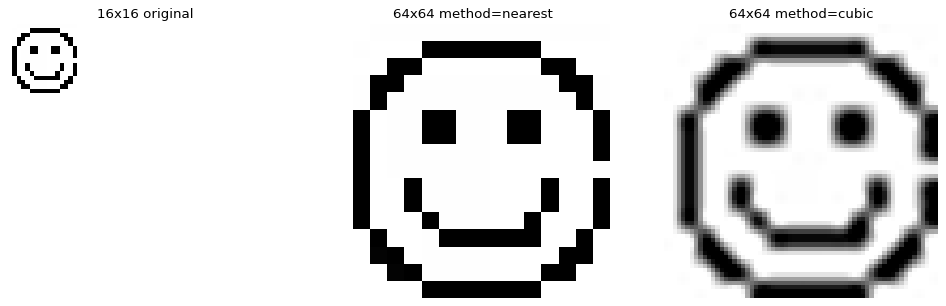

In [2]:
# display with matplotlib
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=80, sharex=True, sharey=True,)
ax[0].imshow(im, cmap='gray')
ax[0].set_title("16x16 original")
ax[0].axis('off')

ax[1].imshow(im_64_nearest)
ax[1].set_title("64x64 method=nearest")
ax[1].axis('off')

ax[2].imshow(im_64_cubic)
ax[2].set_title("64x64 method=cubic")
ax[2].axis('off')

plt.show()

## Standardisation

Image processing will often expect the data to be standardised.

As we've seen that our image data is represented in a numeric 2d or 3d tensor, we can standardise by converting the image
 to have zero mean, and unit variance.

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

im = cv2.imread("data/flower.png")
# convert colour as we're loading in BGR rather than RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

means = np.mean(im, axis=(0,1), keepdims=True)
stds = np.std(im, axis=(0,1), keepdims=True)

print(f"means: {means}")
print(f"stds: {stds}")
print()

# subtract means and divide by stds
result = (im - means) / stds

means: [[[ 43.88558043  72.84690265 187.30281104]]]
stds: [[[34.91541538 48.4553325  52.90432839]]]



(code to display hidden below)

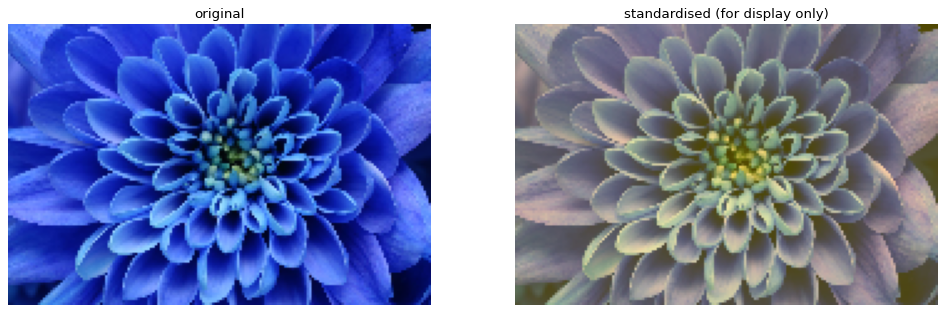

In [4]:
# continue from last
# display with matplotlib
# scale range to [0,255] for display 
for_vis = cv2.normalize(result, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=80, sharex=True, sharey=True,)
ax[0].imshow(im, cmap='gray')
ax[0].set_title("original")
ax[0].axis('off')

ax[1].imshow(for_vis)
ax[1].set_title("standardised (for display only)")
ax[1].axis('off')

plt.show()

Some sanity checks (code and output) for standardisation hidden below.

In [5]:
### sanity checks
# check new means and stds
means, stds = cv2.meanStdDev(result)

# check our new means are 0 (within given tolerance)
np.testing.assert_allclose(means, 0, atol=1e-07)
# check our new stds are 1 (within given tolerance)
np.testing.assert_allclose(stds, 1)


# show top left "pixel"
print(f"original top left: {im[0, 0, :]}")
print(f"standardised top left: {result[0, 0, :]}")
print()

original top left: [ 78 127 249]
standardised top left: [0.97705896 1.11758798 1.16620305]



 
However, for many deep learning tasks, it is common to standardise image data by using precomputed dataset means and standard deviations,
rather than calculate these for each image. For example, using the ImageNet values:

In [6]:
import cv2

im = cv2.imread("data/flower.png")
# convert colour as we're loading in BGR rather than RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

imagenet_means = [0.485, 0.456, 0.406],
imagenet_stds = [0.229, 0.224, 0.225]

# assumes we're in range [0,1] rather than [0,255]
scaled = cv2.normalize(im, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# subtract means and divide by stds
imagenet_result = (scaled - imagenet_means) / imagenet_stds
print(imagenet_result[0,0,:])

[-0.78217308  0.1876752   2.53542511]


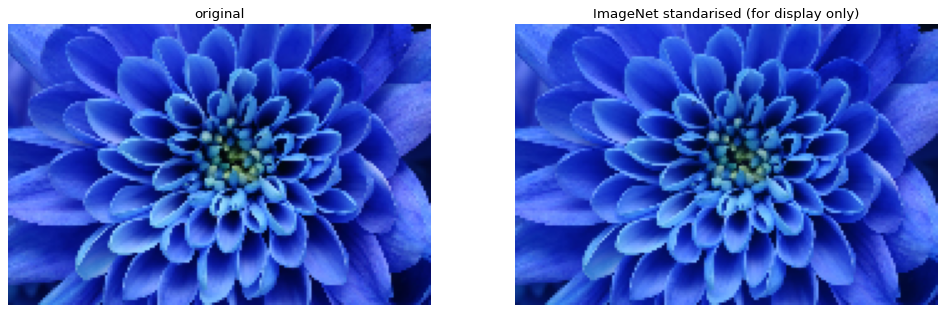

In [7]:
# continue from last
# display with matplotlib
# scale range to [0,255] for display 
imagenet_for_vis = cv2.normalize(imagenet_result, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=80, sharex=True, sharey=True,)
ax[0].imshow(im, cmap='gray')
ax[0].set_title("original")
ax[0].axis('off')

ax[1].imshow(imagenet_for_vis)
ax[1].set_title("ImageNet standarised (for display only)")
ax[1].axis('off')

plt.show()

We see that the image doesn't appear to have been altered to the same extent as before.
This is due to the ImageNet values being less skewed towards the blue channel.

note: many packages like [torchvision](https://pytorch.org/vision/stable/) will have convenience methods to do standardisation/normalisation for you.